# Tradeoffs in speed, precision and flexibility in trafficking in a cable

Summary of simulations:

* We consider an unbranched cable with $N$ compartments

* Each pair of microtubule transport rate constants, $a_i$ and $b_i$ (anterograde and retrograde, respectively), are constrained to sum to 1. Thus the time constant for transport between any two neighboring compartments is always 1.

* The detachment/delivery rate constants for each compartment are denoted $c_i$. For simplicity, we assume that $c_i$ is proportional to the target steady-state distribution for compartment $i$ (see strategy 3 in figure 4B and 4D).

* We assume that there are some number of recently activated synapses distributed along the cable. The "target" steady-state distribution for the transported material is a sequence of double exponential curves, centered around each activated synapse.

* We consider the soma to be the left end of the cable, so all material is initially contained in this compartment.

In [28]:
from __future__ import division
import numpy as np
from scipy.integrate import odeint
from scipy.linalg import expm # matrix exponential solves linear system
import pylab as plt
%matplotlib inline

# JSAnimation import available at https://github.com/jakevdp/JSAnimation
from JSAnimation import IPython_display
from matplotlib import animation

N = 100 # number of compartments
x = np.linspace(0,1,N) # position along cable

def get_matrix(n_syn,timescale,bias,syn_loc):
    """Calculates the state-transition matrix, A"""
    # Calculate target profile, y
    if syn_loc is None: syn_loc = np.linspace(0.1,0.9,n_syn)
    x = np.linspace(0,1,N)
    y = np.zeros(N)
    for i in syn_loc:
        y += 0.5*np.exp(-abs(x - x[int(i*N)])*100)    
    
    # detachment rates
    c = timescale*np.ones(N)
    
    # trafficking rates, constrain so that a+b = 1
    yr = y[1:]/y[:(N-1)]
    a = 1.0/(1.0+(yr**-1))
    b = 1.0/(1.0+yr)
    
    # add trafficking bias:
    a += np.linspace(bias,0,N-1)
    b -= np.linspace(bias,0,N-1)

    mid = -c
    mid[:-1] -= a
    mid[1:]  -= b
    A1 = np.diag(a, -1) + np.diag(mid) + np.diag(b, 1) # Upper-right block
    A2 = np.diag(c) # Lower-left block
    
    # State-transition matrix
    A = np.bmat([[A1,np.zeros((N,N))],[A2,np.zeros((N,N))]])
    
    # initial condition
    u0 = np.zeros(2*N)
    u0[0] = n_syn
    
    return A,u0,y

def run_sim(n_syn,timescale=1e-4,bias=0.0,syn_loc=None):
    A,u0,y = get_matrix(n_syn,timescale,bias,syn_loc)
    
    # time axis
    nt = 40
    t = np.logspace(-np.log10(timescale)-6,-np.log10(timescale)+3,nt)
    
    # animation figure
    fig = plt.figure()
    ax1 = plt.subplot(2,1,1)
    plt.title('concentration on microtubule')
    line1, = ax1.plot([],[],lw=2)
    plt.ylim([-0.02,0.3]),plt.xlim([0,1])
    ax2 = plt.subplot(2,1,2)
    plt.title('detached concentration')
    line2, = ax2.plot([],[],lw=2)
    plt.ylim([-0.02,1.0]),plt.xlim([0,1])
    plt.tight_layout()

    def init():
        line1.set_data(x, u0[:N])
        line2.set_data(x, u0[N:])
        return line1,line2,

    def animate(i):
        u = np.dot(expm(A*t[i]),u0)
        line1.set_data(x, u[:N])
        line2.set_data(x, u[N:])
        return line1,line2,
    
    return fig,animate,init,nt

def save_steady_state(filename,n_syn,timescale=1e-4,bias=0.0,syn_loc=None):
    A,u0,y = get_matrix(n_syn,timescale,bias,syn_loc)
    tss = 10**(-np.log10(timescale)+4)
    uss = np.dot(expm(A*tss),u0) # steady-state profile
    
    plt.figure()
    plt.title('steady-state concentration')
    plt.plot(x,y,'-k',lw=2)
    plt.plot(x,uss[N:],'-r',lw=2)
    plt.ylim([-0.02,1.3]),plt.xlim([0,1])
    plt.legend(('target','steady-state'))
    plt.tight_layout()
    plt.savefig(filename+'.svg')

def calc_tradeoff_curve(n_syn,bias=0.0,syn_loc=None):
    tau,err = [],[]
    for timescale in np.logspace(-4,-1,20):
        A,u0,y = get_matrix(n_syn,timescale,bias,syn_loc)
        w,v = np.linalg.eig(A[:N,:N])
        #print 'timescale = ' + str(timescale**-1)
        #print 'smallest eig = ' + str(w[-1])
        tss = 10**(-np.log10(timescale)+4)
        uss = np.dot(expm(A*tss),u0) # steady-state profile
        err.append(np.sum(np.abs(y-uss[N:])))
        tau.append((-np.max(w))**-1 / N / n_syn) # normalized convergence time constant
    return np.array(tau),np.array(err)

In [29]:
A,u0,y = get_matrix(3,0.0,0.49,None)
np.round(A,3)
b = np.diag(A,1)
a = np.diag(A,-1)
plt.figure()
A[:5,:5]
#plt.yscale('log')
#plt.xscale('log')

matrix([[-1.22303992, -0.22303992,  0.        ,  0.        ,  0.        ],
        [ 1.22303992, -0.995     , -0.21803992,  0.        ,  0.        ],
        [ 0.        ,  1.21803992, -0.995     , -0.21303992,  0.        ],
        [ 0.        ,  0.        ,  1.21303992, -0.995     , -0.20803992],
        [ 0.        ,  0.        ,  0.        ,  1.20803992, -0.995     ]])

### Precise, flexible, but slow trafficking

If the timescale of transport is much faster than the timescale of detachment/delivery, the trafficking process is slow but very flexible and precise. See figure 4 in the main paper. The animation below shows the distribution of material along the microtubules (top subplot) and delivered to the synapses (bottom subplot). For this demonstration we assume there are 6 evenly spaced synaptic sites along the cable.


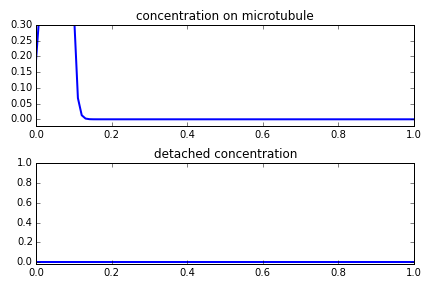
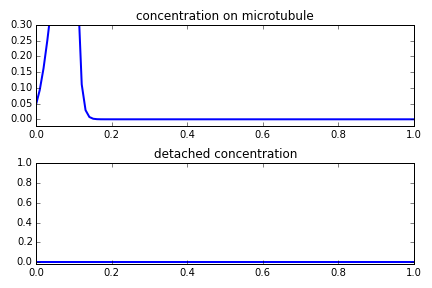
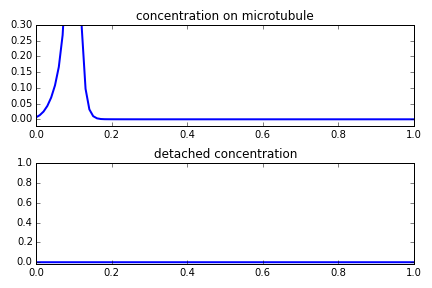
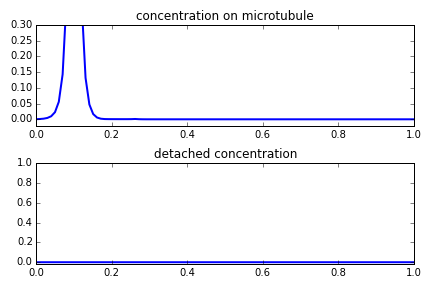
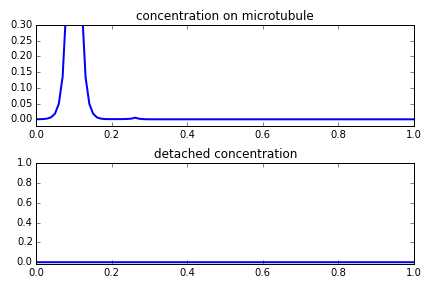
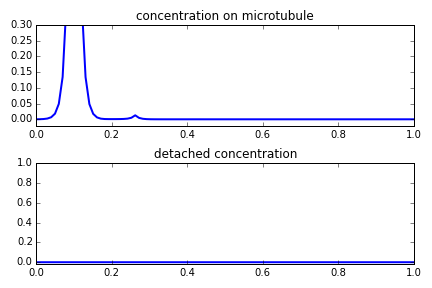
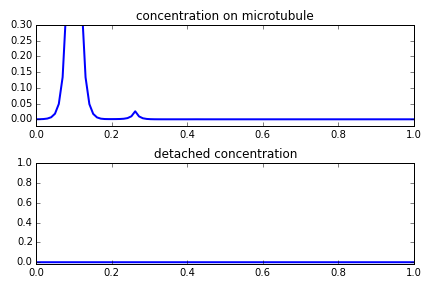
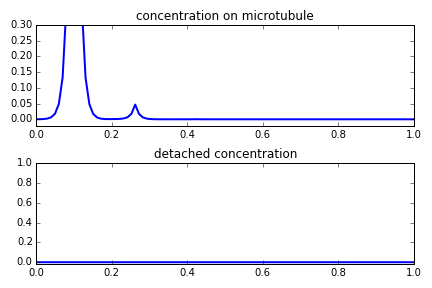
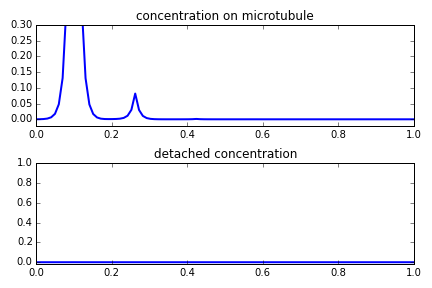
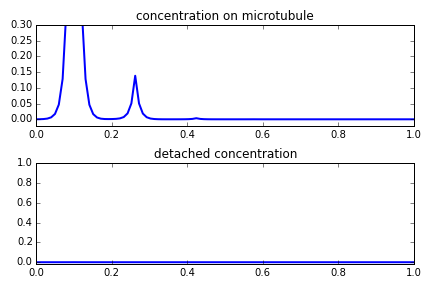
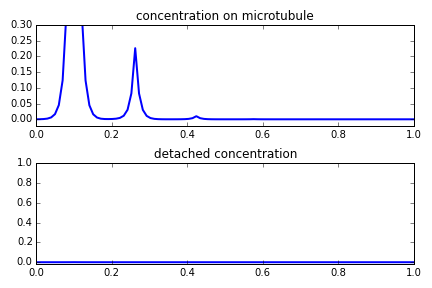
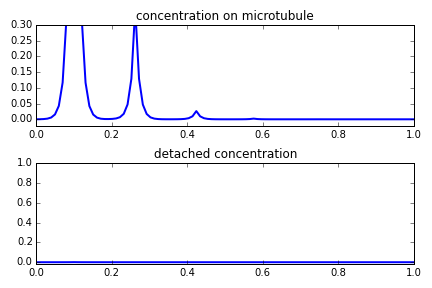
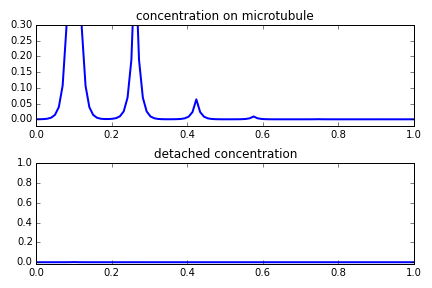
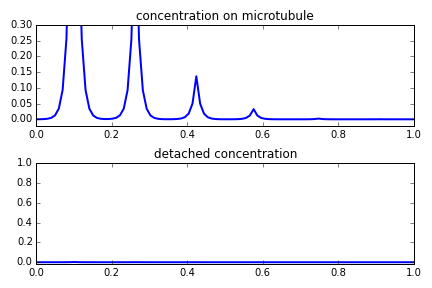
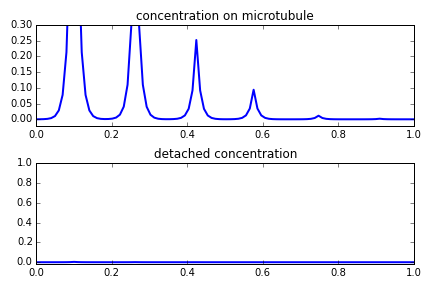
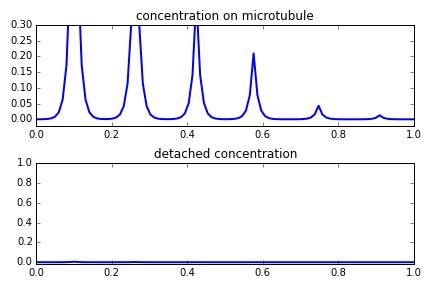
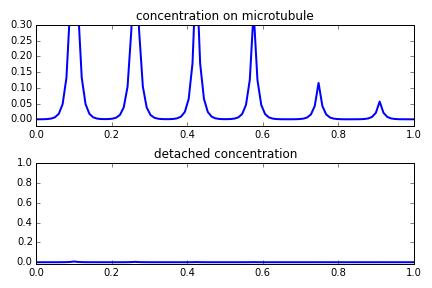
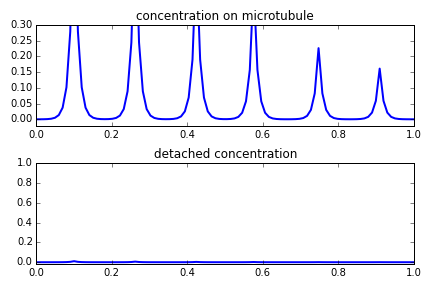
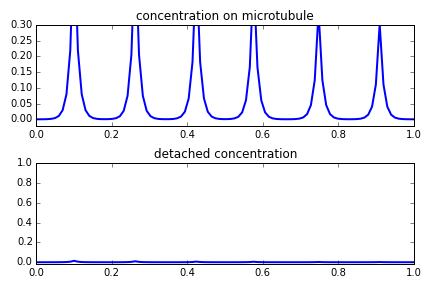
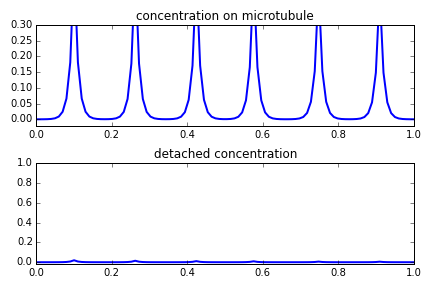
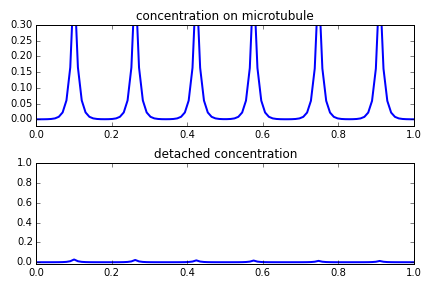
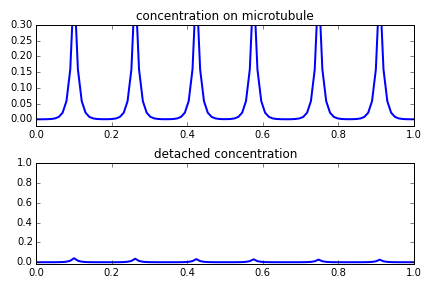
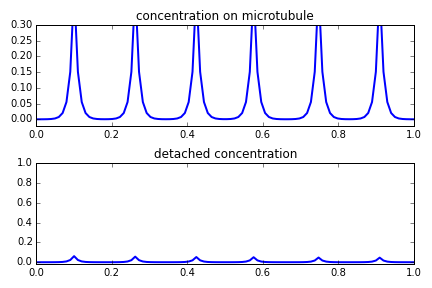
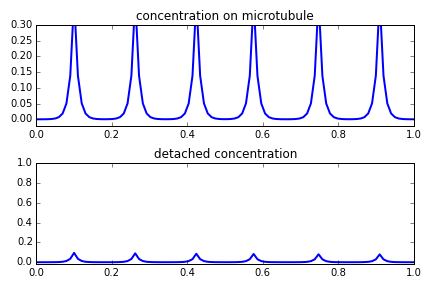
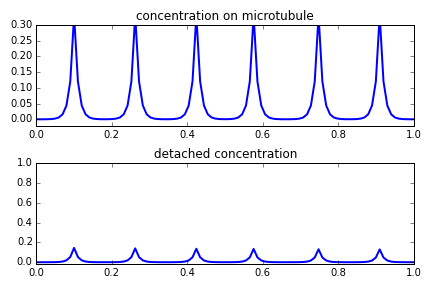
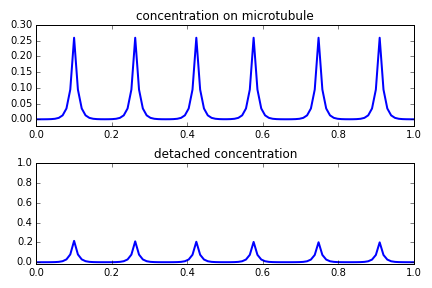
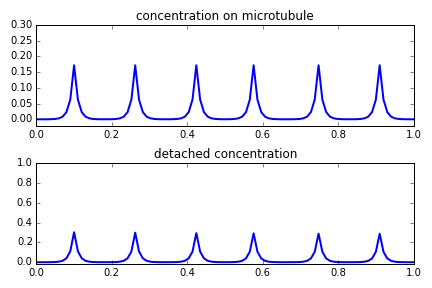
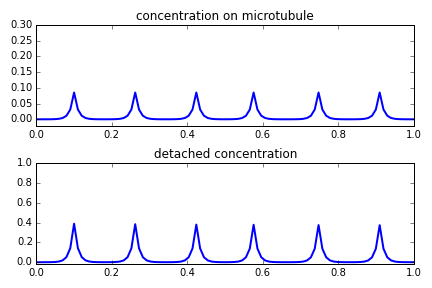
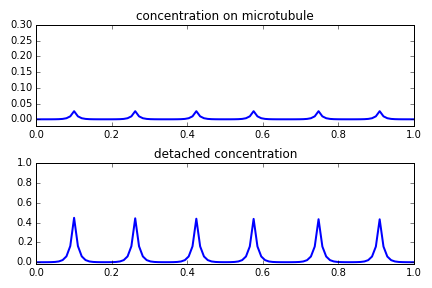
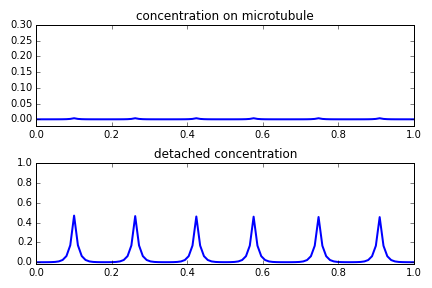
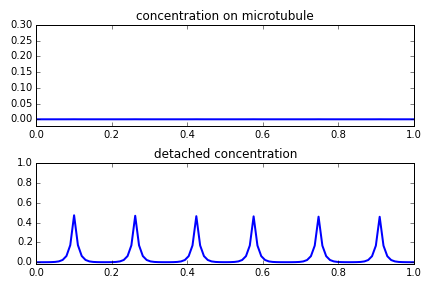
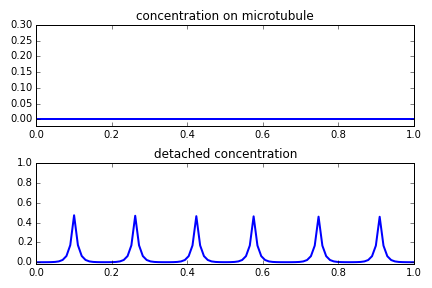
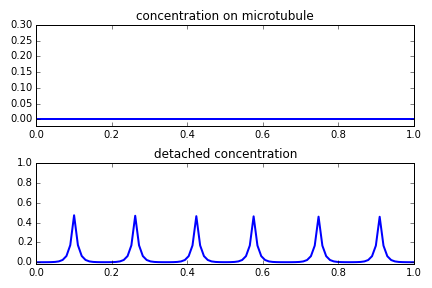
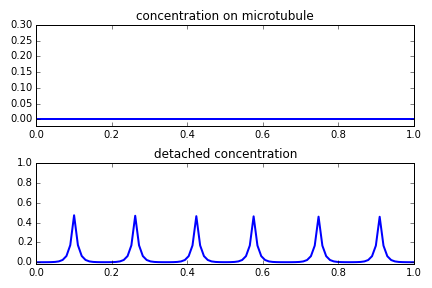
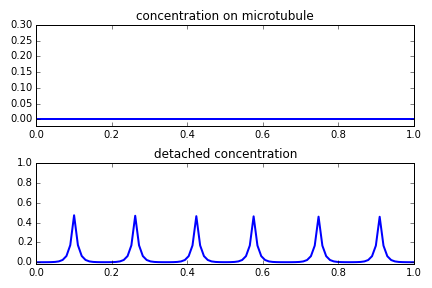
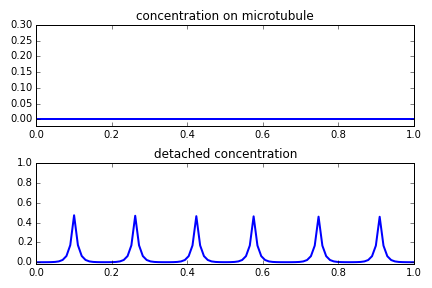
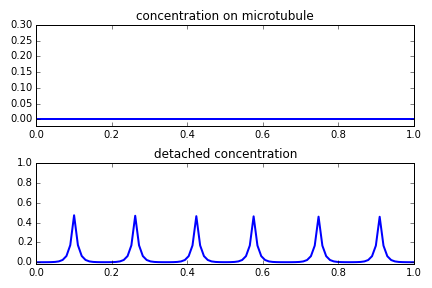
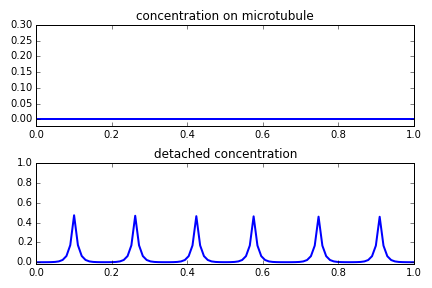
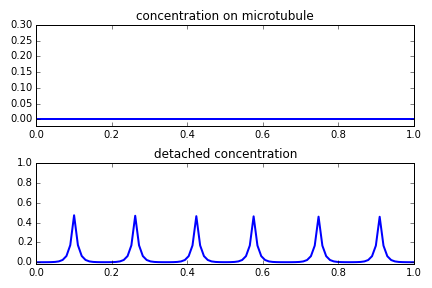
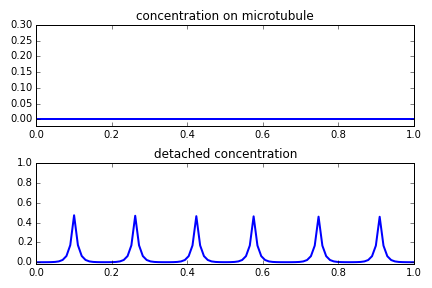

In [30]:
fig,animate,init,nt = run_sim(6,timescale=1e-7)
animation.FuncAnimation(fig, animate, init_func=init, frames=nt, interval=100)

### Fast, nïave transport scheme leads to proximal bias

This is the same phenomenon shown in Figure 5B and 5D, and occurs when the detachment/delivery rate constants, $c_i$, are not sufficiently slower than the transport rate constants.


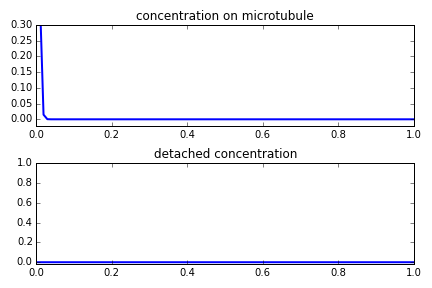
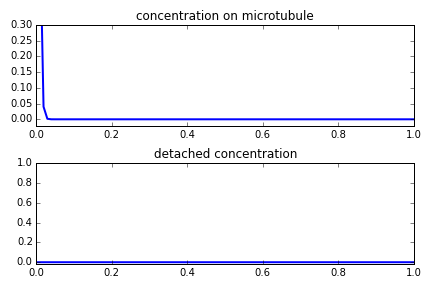
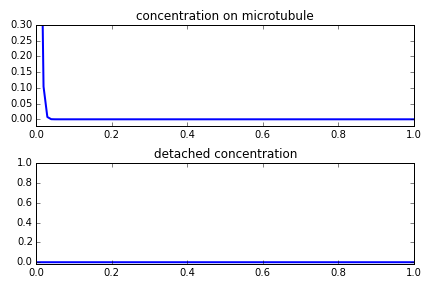
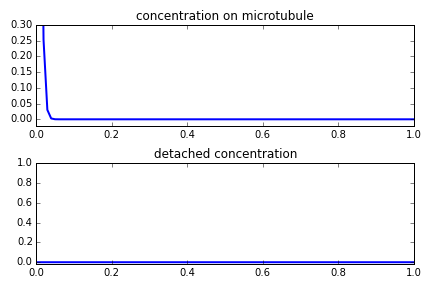
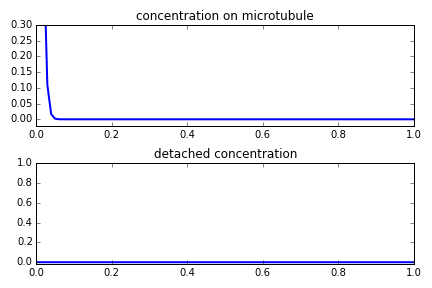
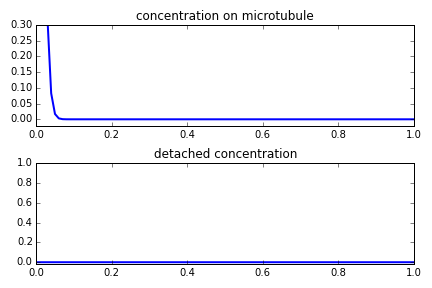
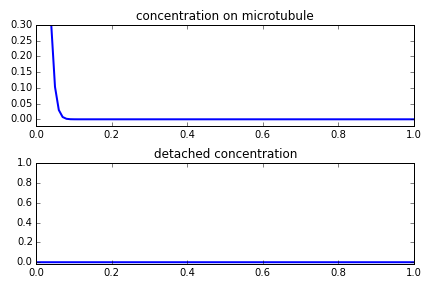
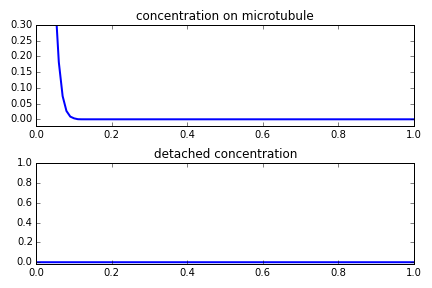
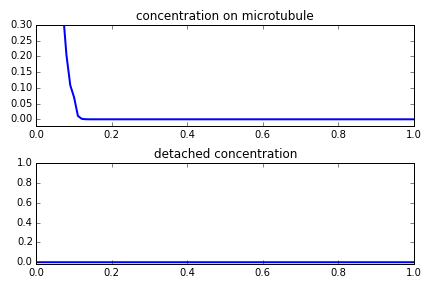
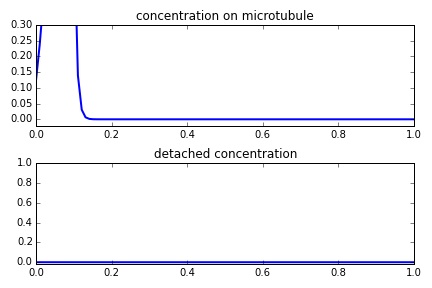
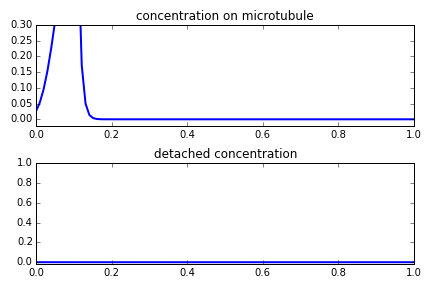
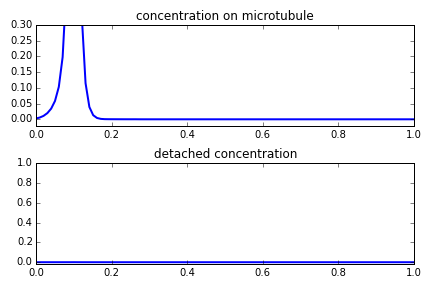
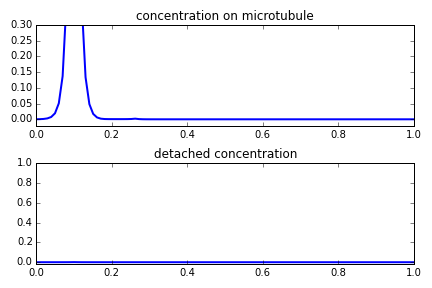
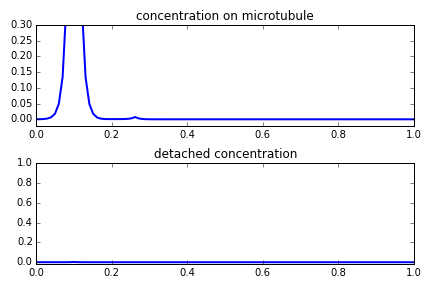
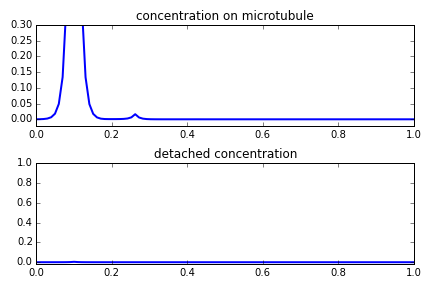
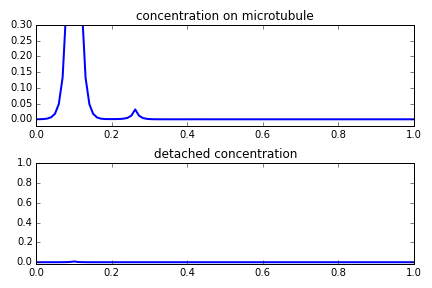
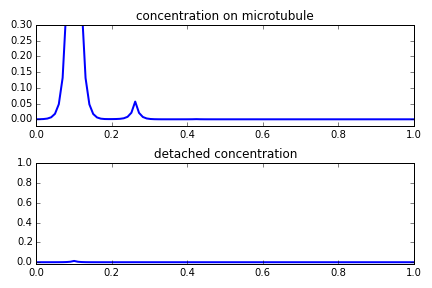
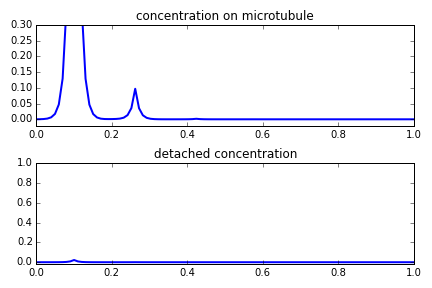
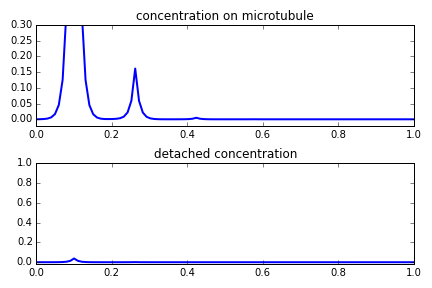
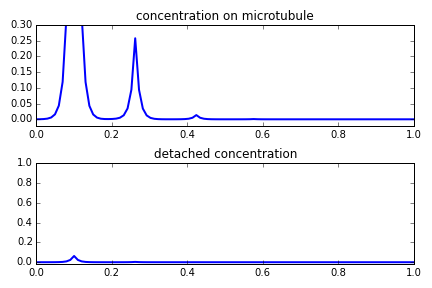
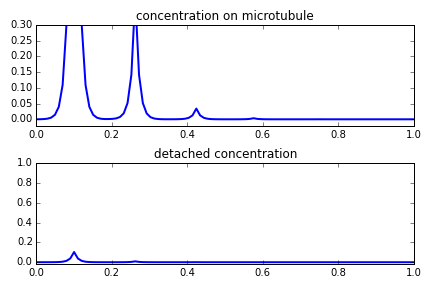
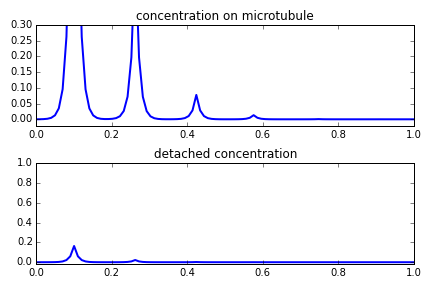
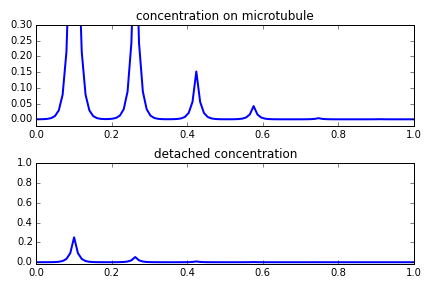
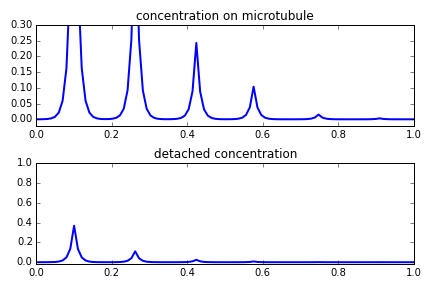
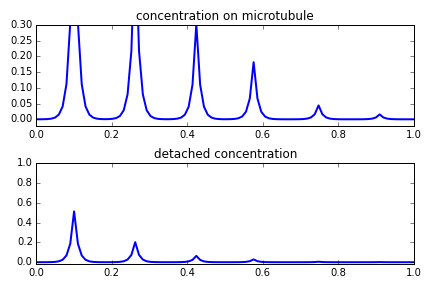
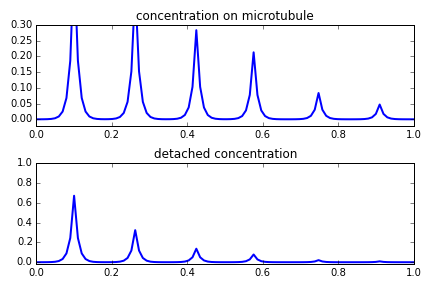
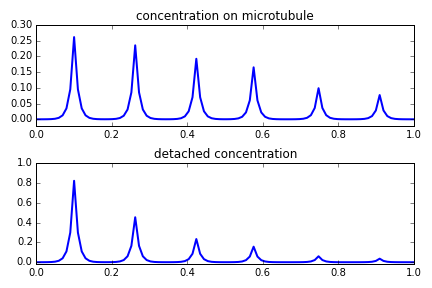
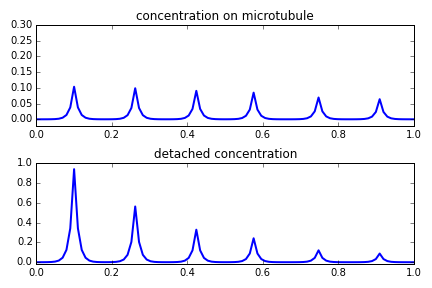
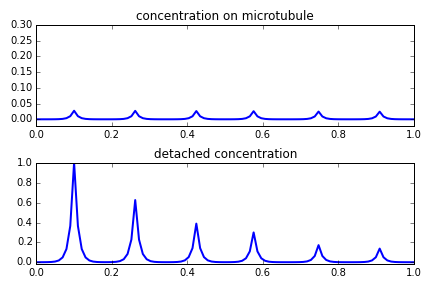
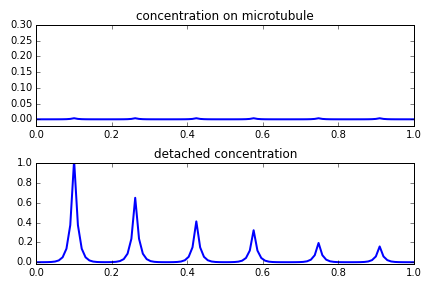
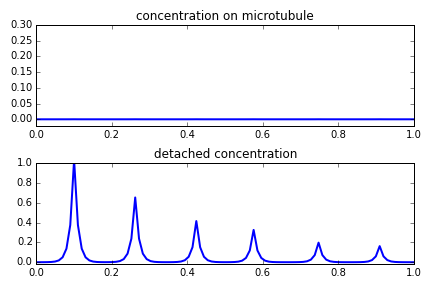
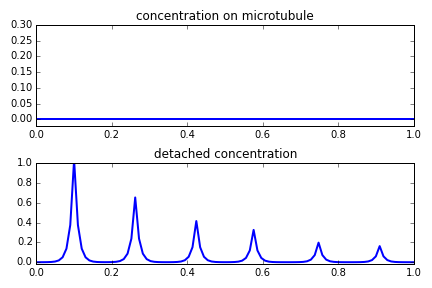
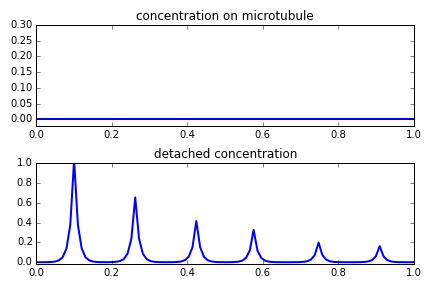
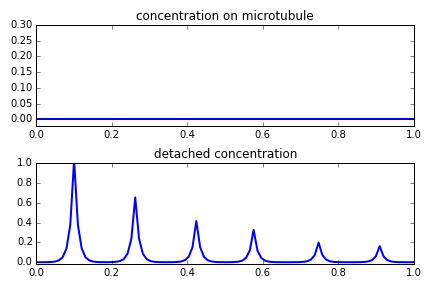
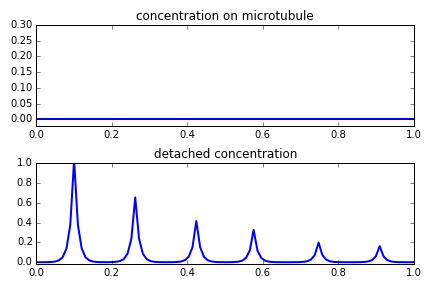
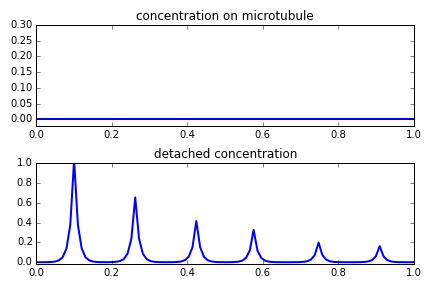
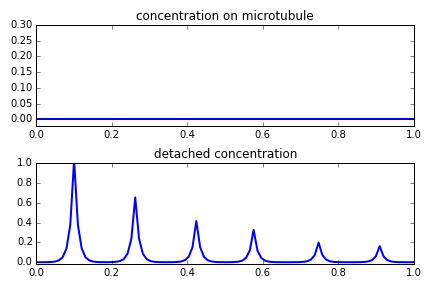
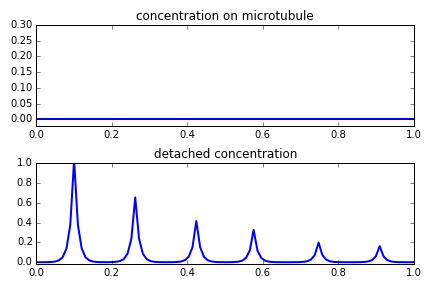
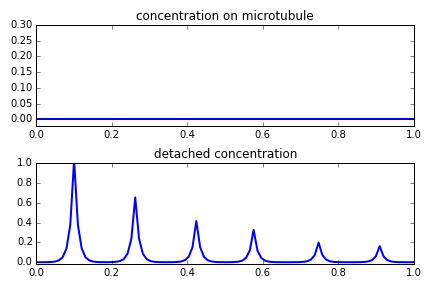
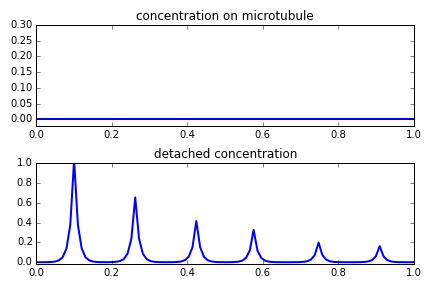

In [31]:
fig,animate,init,nt = run_sim(6,timescale=1e-5)
animation.FuncAnimation(fig, animate, init_func=init, frames=nt, interval=100)

### Can we tweak the transport parameters to improve this? Yes, but at a cost.

To counteract the proximal bias shown in the animation above, we add a bias to the anterograde rate constants ($a_i$) on the left side of the cable. Specifically, we set `a = linspace(0.5+bias,0.5,N)` and `b = linspace(0.5-bias,0.5,N)` so that `a[0] = 0.5+bias` and `b[0] = 0.5-bias` at the left end of the cable; `a[-1] = b[-1] = 0.5` at the right end of the cable. By tuning the `bias` parameter we can produce both fast and precise trafficking for the six evenly spaced synapses.


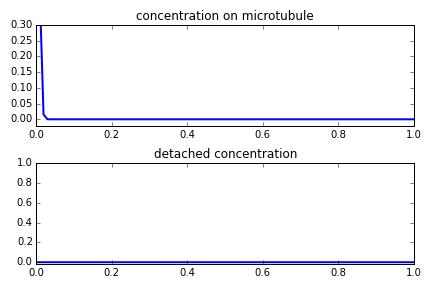
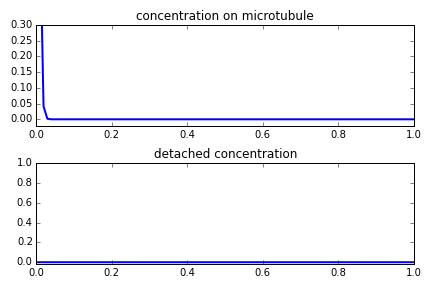
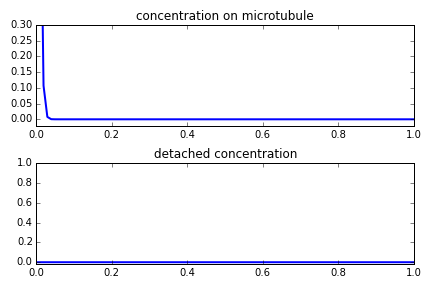
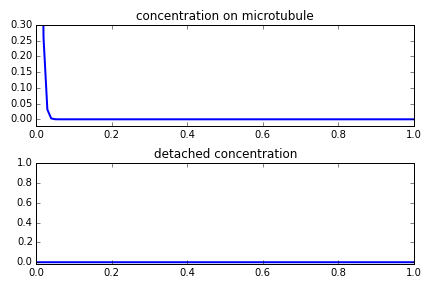
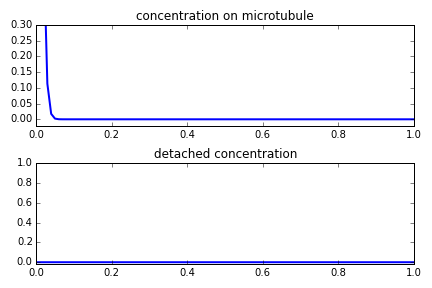
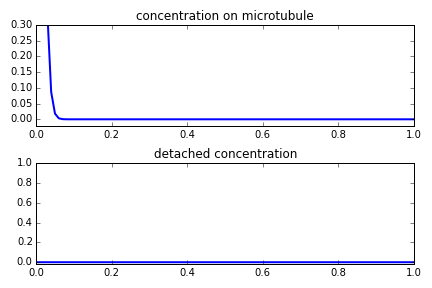
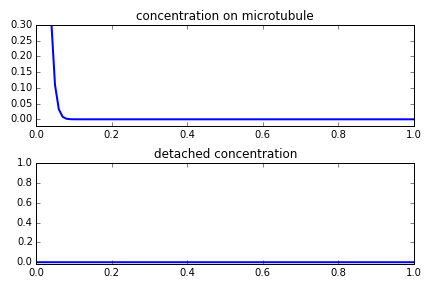
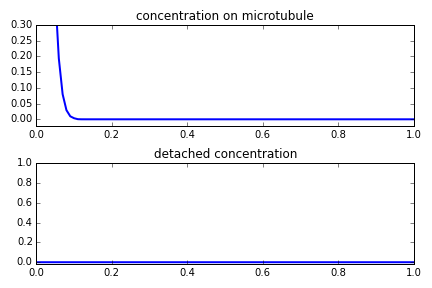
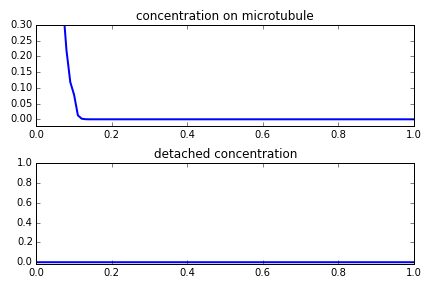
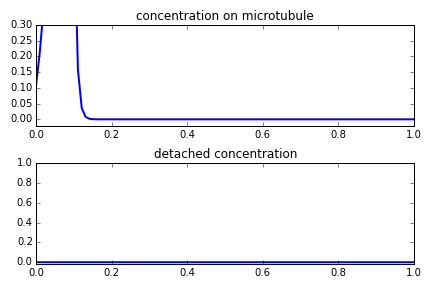
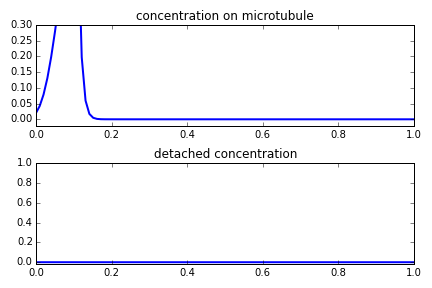
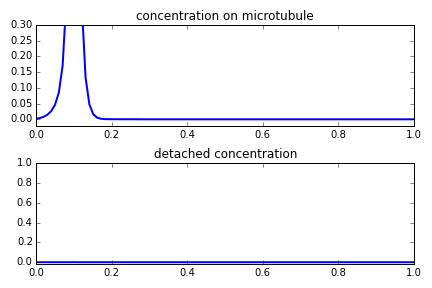
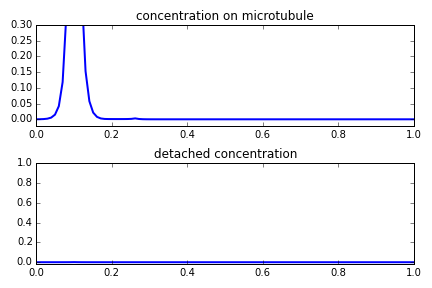
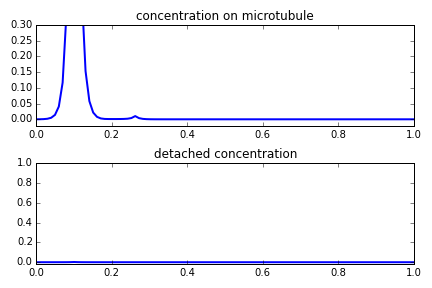
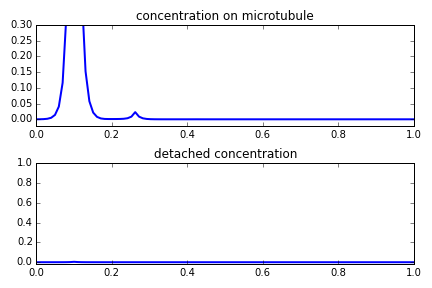
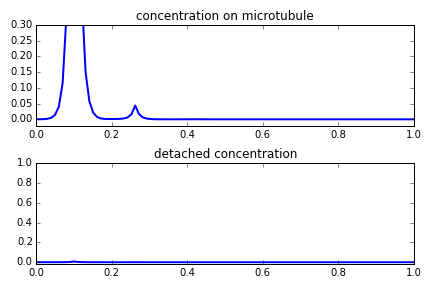
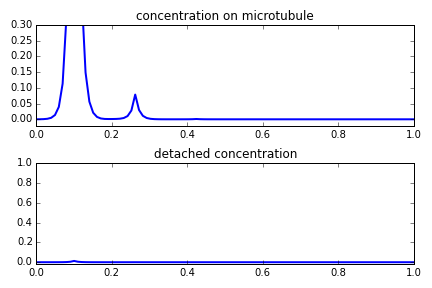
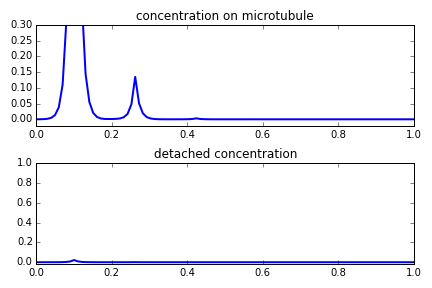
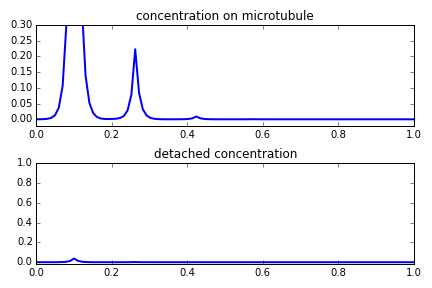
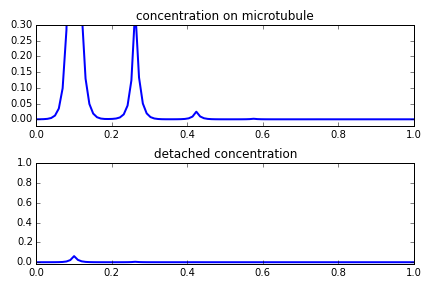
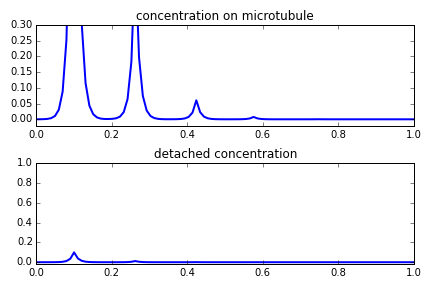
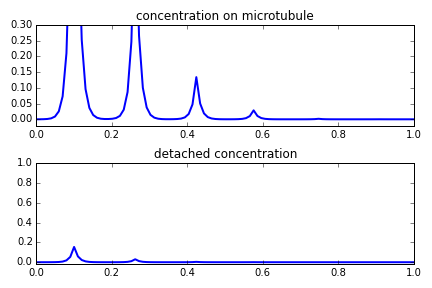
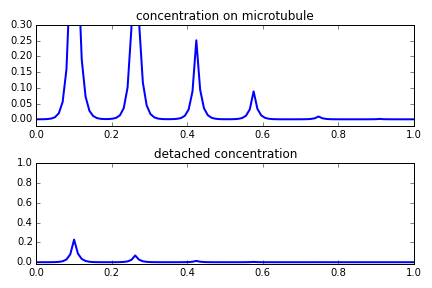
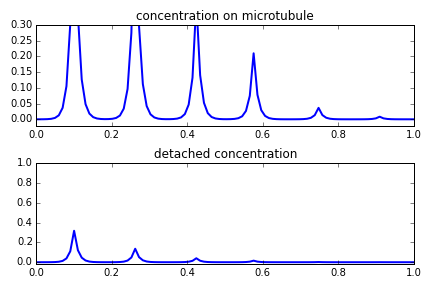
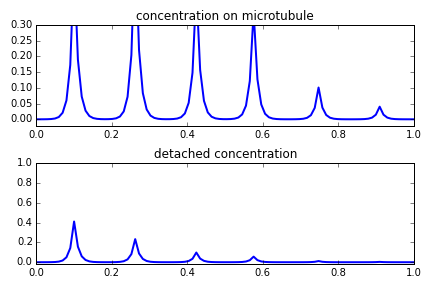
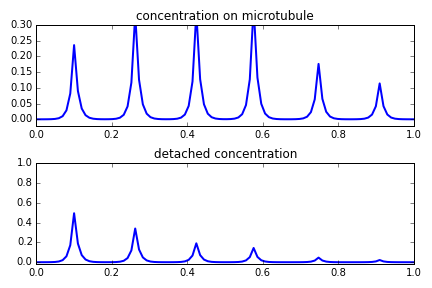
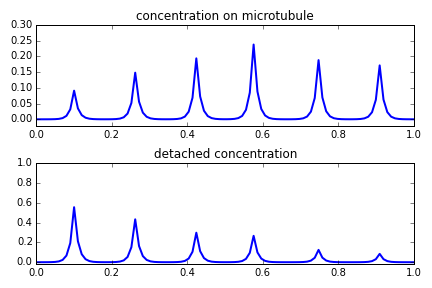
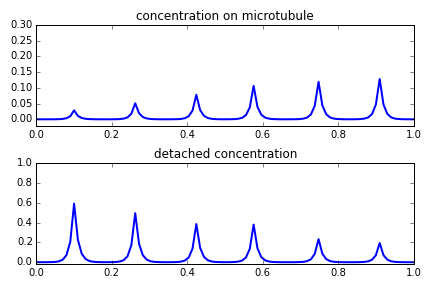
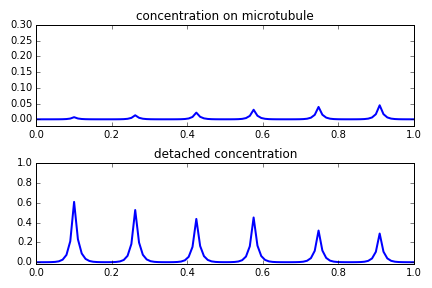
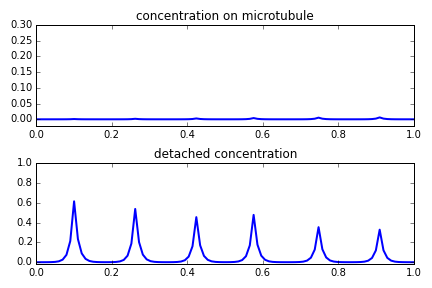
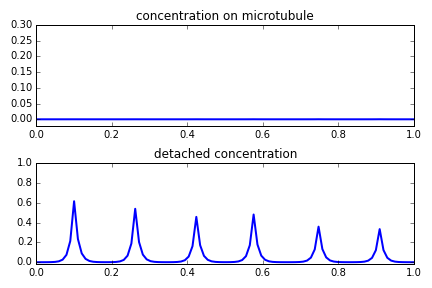
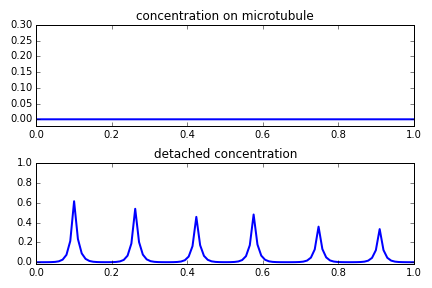
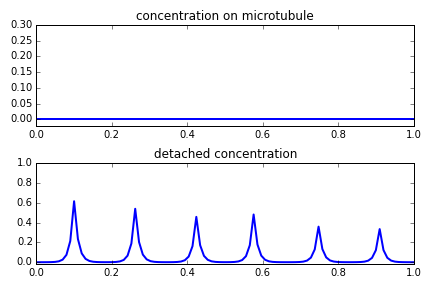
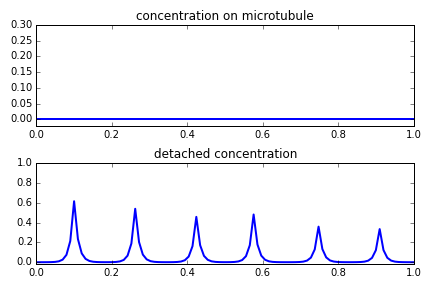
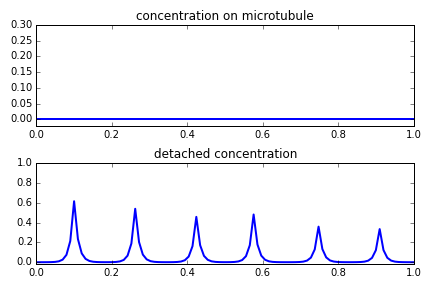
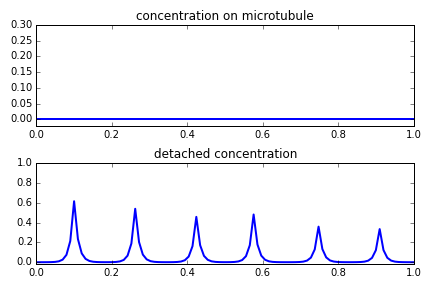
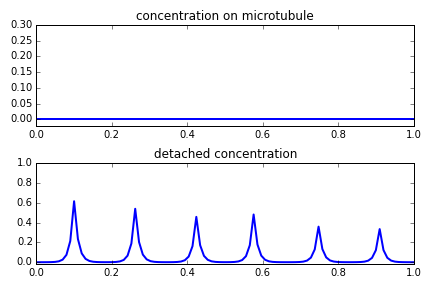
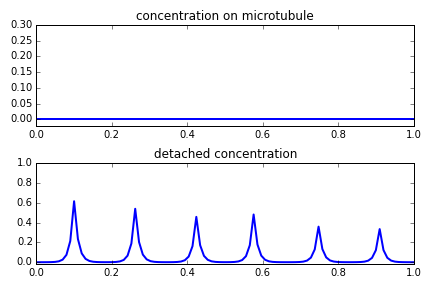
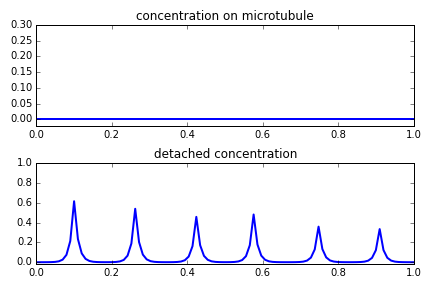
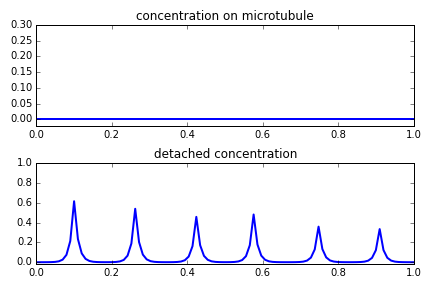

In [35]:
fig,animate,init,nt = run_sim(6,bias=0.01,timescale=1e-5)
animation.FuncAnimation(fig, animate, init_func=init, frames=nt, interval=100)

### There is a cost to this hand-tuning, however

We tuned `bias` to fit a very particular synaptic stimulation pattern: six evenly spaced synapses. What happens when we change this stimulation pattern? If, for example, only 3 synapses are activated, the above model over-corrects and produces a distal bias.


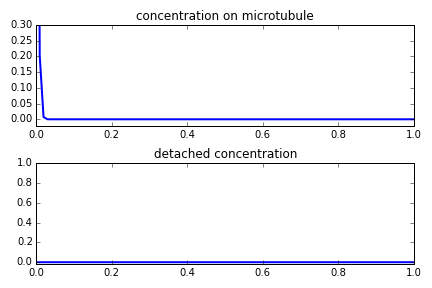
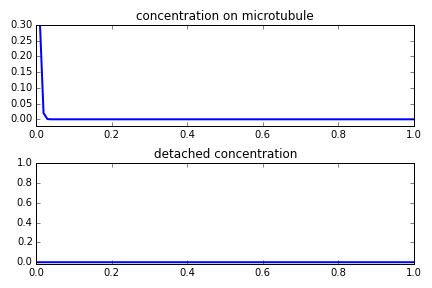
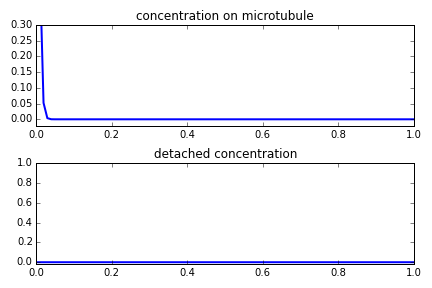
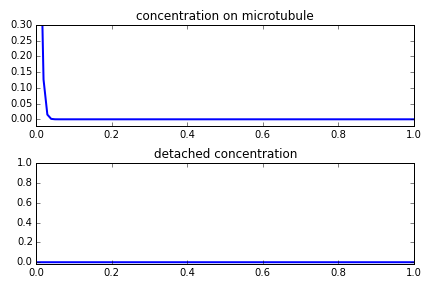
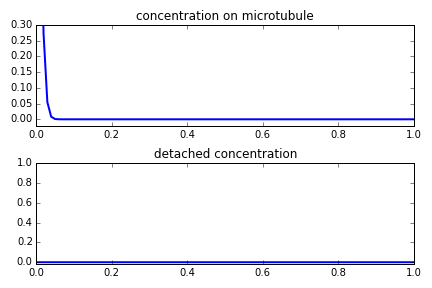
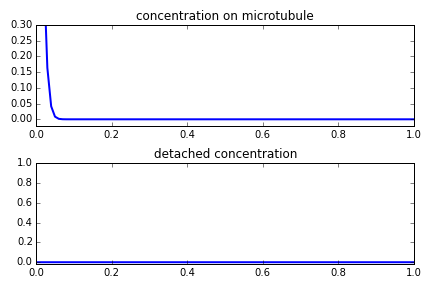
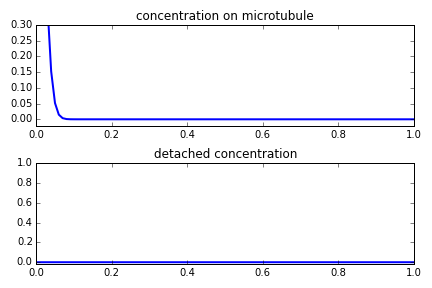
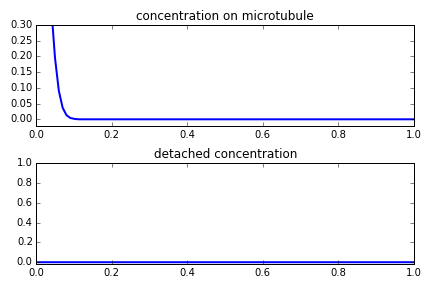
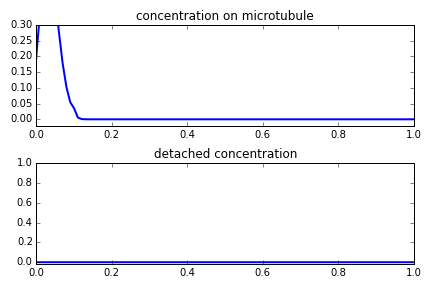
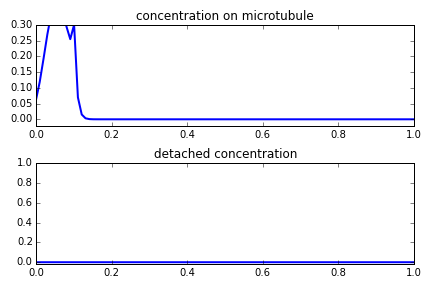
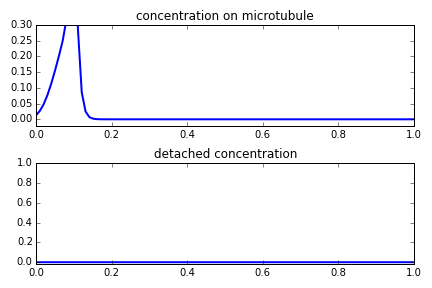
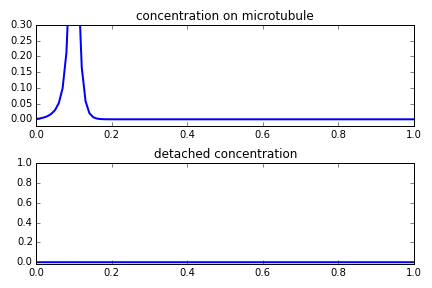
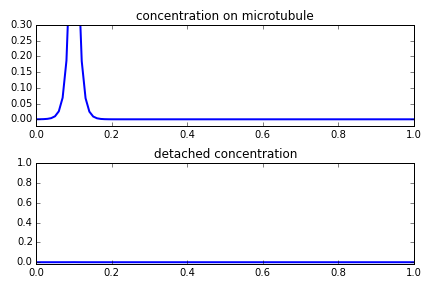
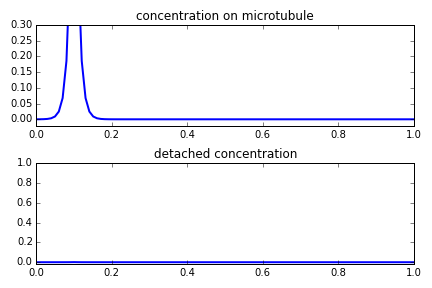
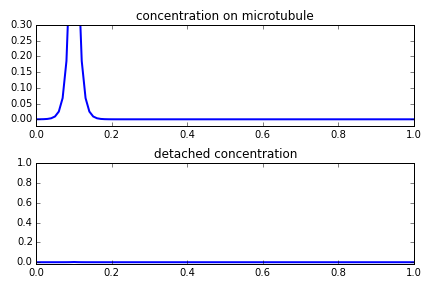
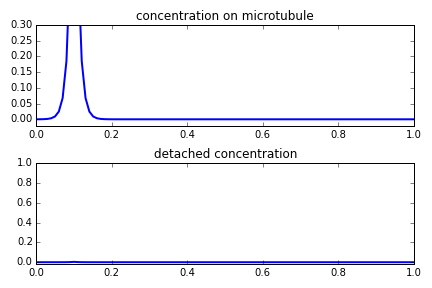
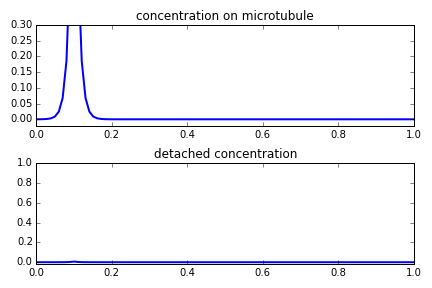
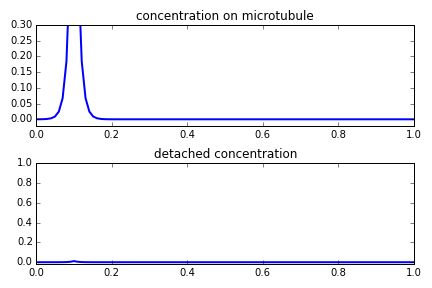
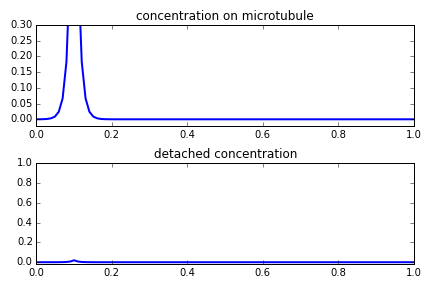
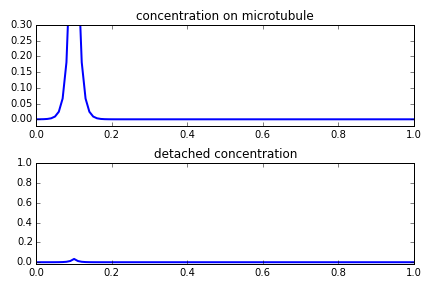
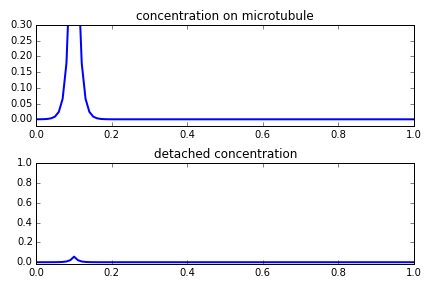
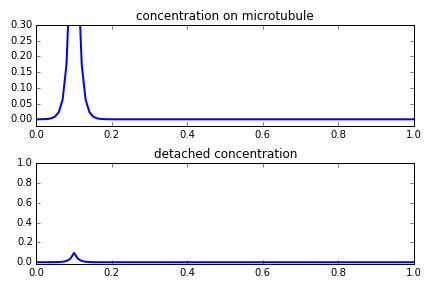
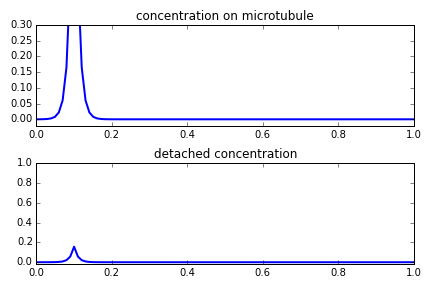
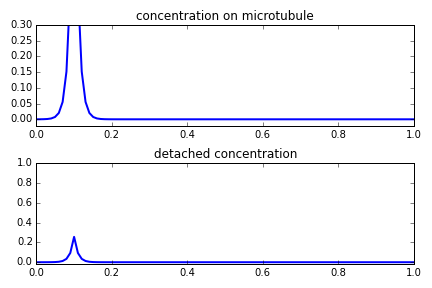
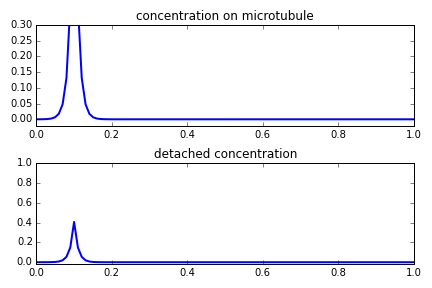
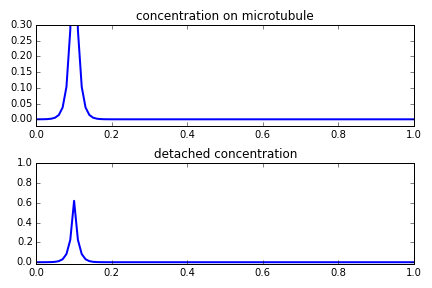
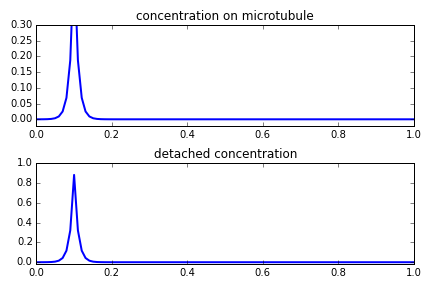
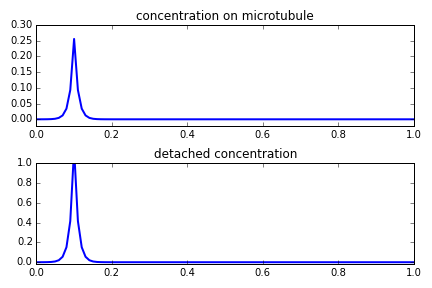
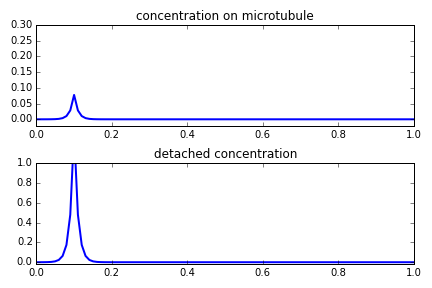
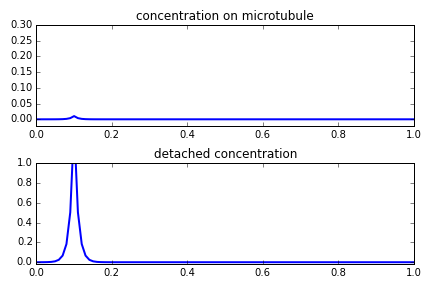
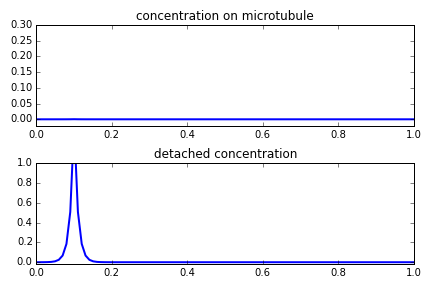
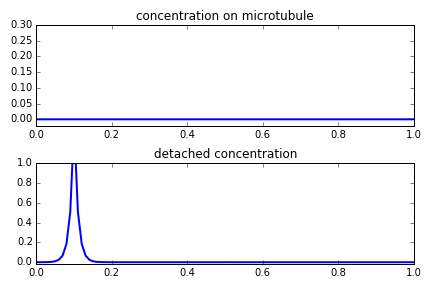
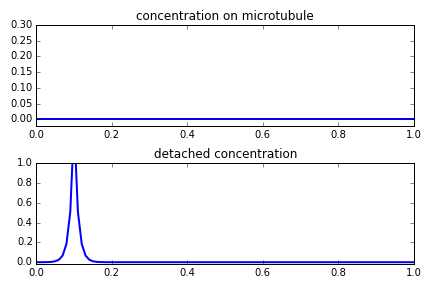
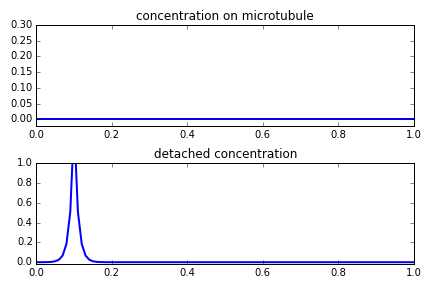
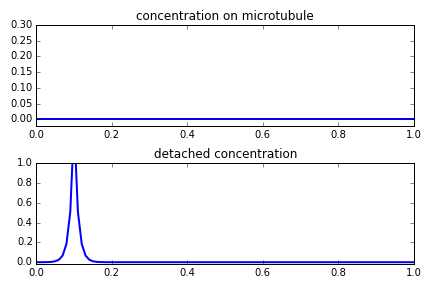
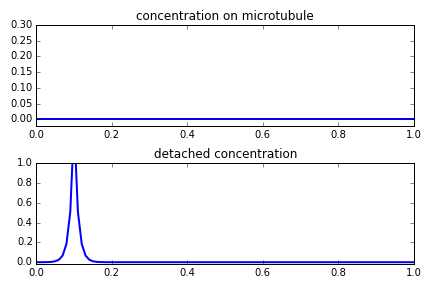
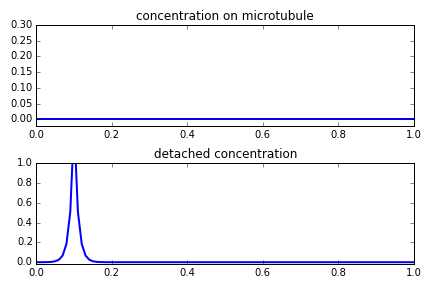
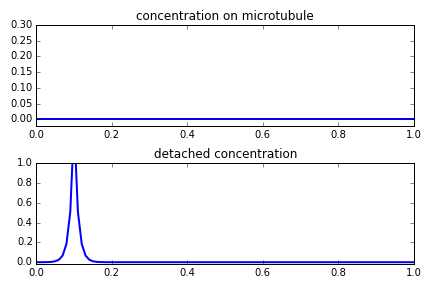
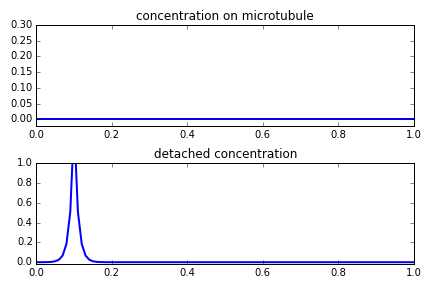
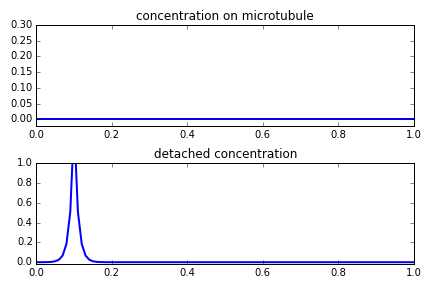

In [23]:
fig,animate,init,nt = run_sim(3,bias=0.032,timescale=1e-5)
animation.FuncAnimation(fig, animate, init_func=init, frames=nt, interval=100)

###Steady-state plots for slow, flexible trafficking model

For all of the following plots, we consider three different stimulation patterns: (a) six evenly spaced synapses, (b) three evenly spaced synapses, and (c) six synapses, five of which are clustered on the proximal end of the cable. The "slow model" is able to precisely produce all of these distributions.

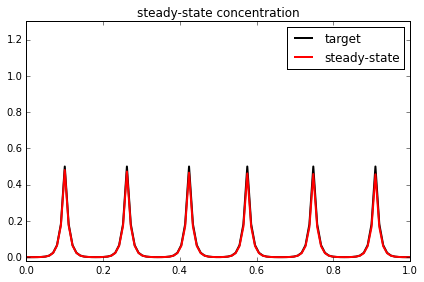

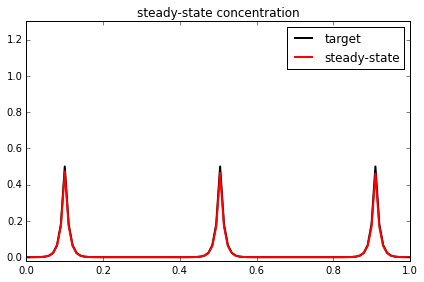

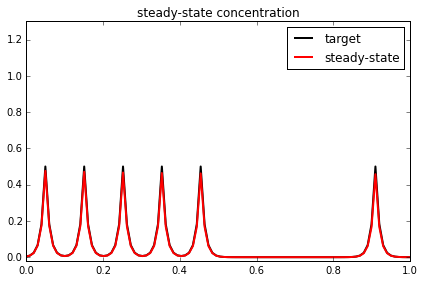

In [7]:
save_steady_state('A1',6,timescale=1e-4)
save_steady_state('A2',3,timescale=1e-4)
save_steady_state('A3',6,timescale=1e-4,syn_loc=[0.05,0.15,0.25,0.35,0.45,0.9])

###Steady-state plots for nïave, fast transport (leading to proximal bias)

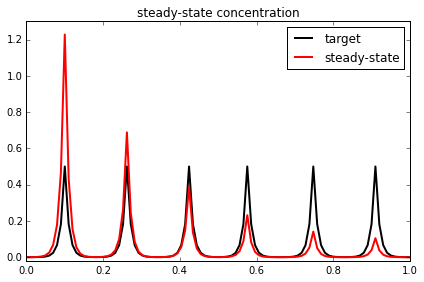

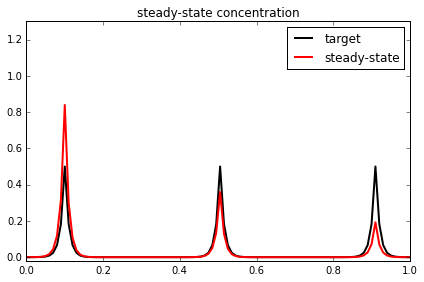

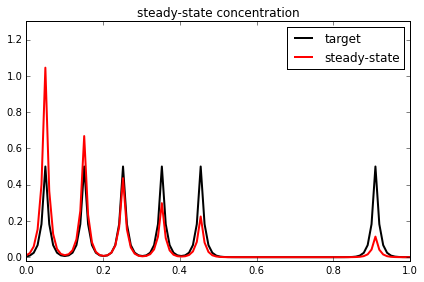

In [8]:
save_steady_state('B1',6,timescale=1e-2)
save_steady_state('B2',3,timescale=1e-2)
save_steady_state('B3',6,timescale=1e-2,syn_loc=[0.05,0.15,0.25,0.35,0.45,0.9])

### Steady-state plots for tuned model (fast, optimized for six evenly spaced synapses)

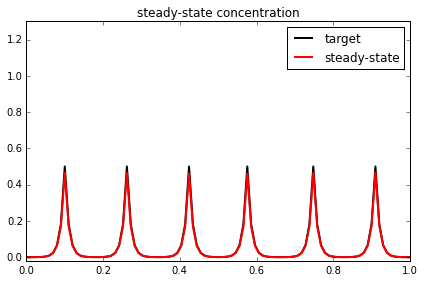

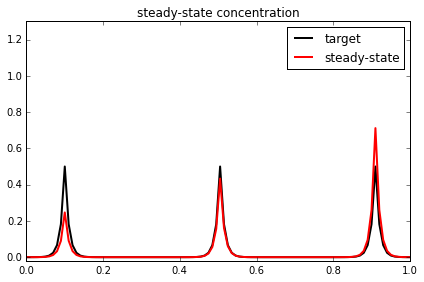

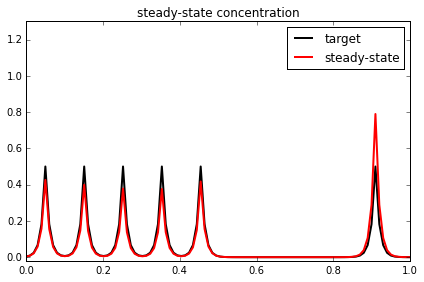

In [9]:
save_steady_state('C1',6,bias=0.032,timescale=1e-2)
save_steady_state('C2',3,bias=0.032,timescale=1e-2)
save_steady_state('C3',6,bias=0.032,timescale=1e-2,syn_loc=[0.05,0.15,0.25,0.35,0.45,0.9])

### Tradeoff curves for error vs. speed for various levels of `bias`

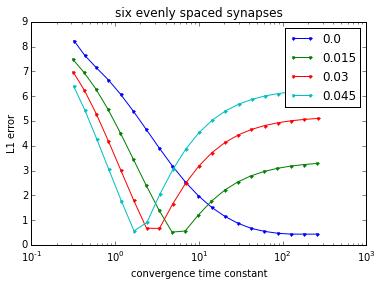

In [10]:
plt.figure()
bias_levels = [0.0,0.015,0.03,0.045] 
for bias in bias_levels:
    tau,err = calc_tradeoff_curve(6,bias=bias)
    plt.plot(tau,err,'.-')
plt.xscale('log')
plt.xlabel('convergence time constant')
plt.ylabel('L1 error')
plt.title('six evenly spaced synapses')
plt.legend(bias_levels)
plt.savefig('D.svg')

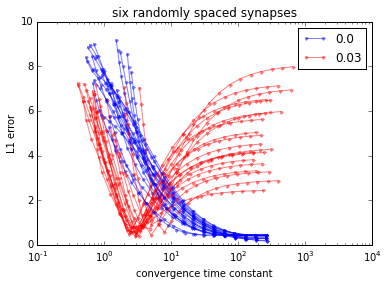

In [11]:
plt.figure()
bias_levels = [0.0,0.03]
for r in range(20):
    loc = np.random.uniform(0,1,6)
    for bias,color in zip(bias_levels,['b','r']):
        tau,err = calc_tradeoff_curve(len(loc),bias=bias,syn_loc=loc)
        plt.plot(tau,err,'.-',alpha=0.5,color=color)
plt.xscale('log')
plt.xlim([1e-1,1e4])
plt.xlabel('convergence time constant')
plt.ylabel('L1 error')
plt.title('six randomly spaced synapses')
plt.legend(bias_levels)
plt.savefig('E.svg')

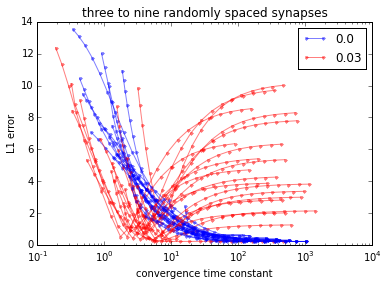

In [12]:
plt.figure()
bias_levels = [0.0,0.03]
for r in range(20):
    loc = np.random.uniform(0,1,np.random.randint(3,10))
    plt.gca().set_color_cycle(None)
    for bias,color in zip(bias_levels,['b','r']):
        tau,err = calc_tradeoff_curve(len(loc),bias=bias,syn_loc=loc)
        plt.plot(tau,err,'.-',alpha=0.5,color=color)
plt.xscale('log')
plt.xlim([1e-1,1e4])
plt.xlabel('convergence time constant')
plt.ylabel('L1 error')
plt.title('three to nine randomly spaced synapses')
plt.legend(bias_levels)
plt.savefig('F.svg')